In [ ]:
# Install python-dotenv
!pip install python-dotenv

# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Load the .env file from Google Drive
from dotenv import load_dotenv
import os

# Change the path to where you have uploaded your .env file
dotenv_path = '/content/drive/MyDrive/Colab Notebooks/Youtube_Statistics_Nigeria_Videos/.env'
load_dotenv(dotenv_path)

# Access the environment variables
api_key = os.getenv('my_api_key')

# print(f'API_KEY: {api_key}')

In [ ]:
# Install google api python client
#!pip install google-api-python-client

### Getting the top 1000 most popular videos in Nigeria for the past 12 months.

In [ ]:

from googleapiclient.discovery import build
from datetime import datetime, timedelta
import pytz

# Initialize the YouTube API client
youtube = build('youtube', 'v3', developerKey=api_key)

# Get the date one year ago from today
one_year_ago = (datetime.now(pytz.timezone('Africa/Lagos')) - timedelta(days=365)).isoformat("T")

# Function to get videos with pagination
def get_videos(region_code, max_results, published_after):
    videos = []
    next_page_token = None

    while len(videos) < max_results:
        # Use search.list to find videos
        search_request = youtube.search().list(
            part='id',
            type='video',
            regionCode=region_code,
            maxResults=50,
            pageToken=next_page_token,
            publishedAfter=published_after
        )
        search_response = search_request.execute()

        # Collect video IDs
        video_ids = [item['id']['videoId'] for item in search_response['items']]

        # Get video details using videos.list
        if video_ids:
            video_request = youtube.videos().list(
                part='snippet,contentDetails,statistics',
                id=','.join(video_ids)
            )
            video_response = video_request.execute()
            videos.extend(video_response['items'])

        next_page_token = search_response.get('nextPageToken')

        if not next_page_token:
            break

    return videos[:max_results]

# Function to sort videos by view count
def sort_videos_by_views(videos):
    return sorted(videos, key=lambda x: int(x['statistics']['viewCount']), reverse=True)

# Get the top 1000 most popular videos
videos = get_videos('NG', 1000, one_year_ago)
popular_videos = sort_videos_by_views(videos)[:1000]

### Save output to a csv file

In [ ]:
import csv
from google.colab import files

# Save the output to a CSV file
with open('popular_videos.csv', 'w', newline='') as csvfile:
    writer = csv.writer(csvfile)
    writer.writerow(['video_id', 'title', 'published_at', 'view_count', 'duration', 'tags'])  # header row with added tags column
    for video in popular_videos:
        video_id = video['id']
        duration_request = youtube.videos().list(
            part='contentDetails',
            id=video_id
        )
        duration_response = duration_request.execute()
        duration = duration_response['items'][0]['contentDetails']['duration']

        tags_request = youtube.videoCategories().list(
            part='snippet',
            id=video_id
        )
        tags_response = tags_request.execute()
        tags = ','.join([tag['snippet']['title'] for tag in tags_response['items']])

        writer.writerow([video['id'], video['snippet']['title'], video['snippet']['publishedAt'], video['statistics']['viewCount'], duration, tags])
# Download the file
files.download('popular_videos.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

### Save output to a .json file

In [ ]:
import json
with open('popular_videos.json', 'w') as jsonfile:
    json.dump(popular_videos, jsonfile, indent=4)

# Download the file
files.download('popular_videos.json')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

### Import the csv file for analysis

In [9]:
import pandas as pd
popular_videos = pd.read_csv(r"/content/drive/MyDrive/Colab Notebooks/Youtube_Statistics_Nigeria_Videos/popular_videos (1).csv")

popular_videos.head()

,video_id,title,published_at,view_count,duration,tags
0,Jz_ACml012M,blind man 🤣🤣#abdulbkcomedy #funny #newfunnycom...,2023-12-24T19:01:38Z,252504010,PT19S,NaN
1,DCmKq1eu-Rs,I Did the imposible 🤯🫣 #sherco #BIKE #HIGHT...,2024-04-03T10:10:54Z,220987865,PT13S,NaN
2,7dok_dhNiMY,respect 😱🔥🤯,2024-06-16T13:50:09Z,56819874,PT25S,NaN
3,6mJzLrCGMb0,Catching fish with a dustpan Do you like this ...,2024-06-03T03:44:45Z,48723564,PT20S,NaN
4,OLbUNiCBY6M,GTA V KARMA Spidey and Hulk #gta,2024-06-24T11:09:30Z,46645275,PT7S,NaN


In [10]:
popular_videos.shape

(592, 6)

In [11]:
duration_counts = popular_videos['duration'].value_counts()
duration_counts

,count
duration,
PT1M1S,45
PT1M,40
PT19S,13
PT59S,12
PT20S,11
...,...
PT2H57M44S,1
PT18M58S,1
PT1H41M58S,1


In [12]:
tag_counts = popular_videos['tags'].value_counts()
print(tag_counts)

Series([], Name: count, dtype: int64)


Since the "tags" column is empty, it will be dropped.

Using the "duration" column, a new column will be created to group the videos based on the following criteria. if the duration is;
- less than ten minutes - "<10mins"
- between 10mins and 1hr  - "10mins - 1hr"
- btween 1hr and 2hrs - "1hr - 2hr"
- above 2hrs - ">2hrs"

In [13]:
import numpy as np
popular_videos['duration'] = pd.to_timedelta(popular_videos['duration'])

conditions = [
    popular_videos['duration'] < '0 days 00:10:00',
    (popular_videos['duration'] >= '0 days 00:10:00') & (popular_videos['duration'] < '0 days 01:00:00'),
    (popular_videos['duration'] >= '0 days 01:00:00') & (popular_videos['duration'] < '0 days 02:00:00'),
    popular_videos['duration'] >= '0 days 02:00:00'
]

choices = ['<10mins', '10mins - 1hr', '1hr - 2hr', '>2hrs']

popular_videos['duration_range'] = np.select(conditions, choices)

#drop the "tags" column
popular_videos.drop(columns=['tags'], inplace=True)

popular_videos.head()

,video_id,title,published_at,view_count,duration,duration_range
0,Jz_ACml012M,blind man 🤣🤣#abdulbkcomedy #funny #newfunnycom...,2023-12-24T19:01:38Z,252504010,0 days 00:00:19,<10mins
1,DCmKq1eu-Rs,I Did the imposible 🤯🫣 #sherco #BIKE #HIGHT...,2024-04-03T10:10:54Z,220987865,0 days 00:00:13,<10mins
2,7dok_dhNiMY,respect 😱🔥🤯,2024-06-16T13:50:09Z,56819874,0 days 00:00:25,<10mins
3,6mJzLrCGMb0,Catching fish with a dustpan Do you like this ...,2024-06-03T03:44:45Z,48723564,0 days 00:00:20,<10mins
4,OLbUNiCBY6M,GTA V KARMA Spidey and Hulk #gta,2024-06-24T11:09:30Z,46645275,0 days 00:00:07,<10mins


### Plot the duration of each video against the number of views they have to know which video length tends to perform best.

In [19]:
# Calculate the percentage of videos in each 'duration_range'
duration_range_counts = popular_videos['duration_range'].value_counts(normalize=True) * 100

# Format the percentages to 2 decimal places and add a percent sign
duration_range_counts = duration_range_counts.apply(lambda x: f"{x:.2f}%")

# Display the formatted percentages
print("Percentage of videos in each duration range:")
print(duration_range_counts)


Percentage of videos in each duration range:
duration_range
<10mins         71.62%
1hr - 2hr       12.50%
10mins - 1hr    10.14%
>2hrs            5.74%
Name: proportion, dtype: object


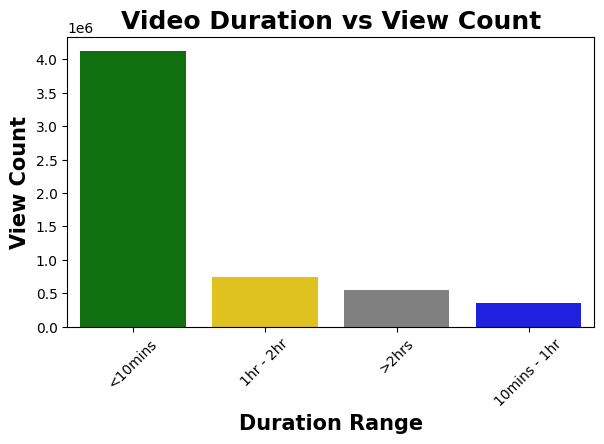

In [14]:

import seaborn as sns
import matplotlib.pyplot as plt

# Create a barplot of duration_range vs view counts
sns.barplot(x='duration_range', y='view_count',
            data=popular_videos, errorbar=None,
            hue='duration_range', legend=False,
            palette=['green', 'gold', 'grey', 'blue'])

# Customize the plot
plt.title('Video Duration vs View Count', fontweight='bold', fontsize=18)
plt.xlabel('Duration Range', fontweight='bold', fontsize=15)
plt.ylabel('View Count', fontweight='bold', fontsize=15)
plt.xticks(rotation=45)
plt.rcParams['axes.facecolor'] = 'white'
plt.tight_layout(pad=2)

# Show the plot
plt.show()


*From the above plot, we can see that, by far, videos below 10 minutes long tend to perform best with videos between 1hr and 2hrs coming a distant second with a difference of over 3.5million views.*

*Videos above 2hrs and videos between 10mins-1hr perform the least.*

###Now, let's figure out what tags/keywords title tends to perform the most using deep learning.

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


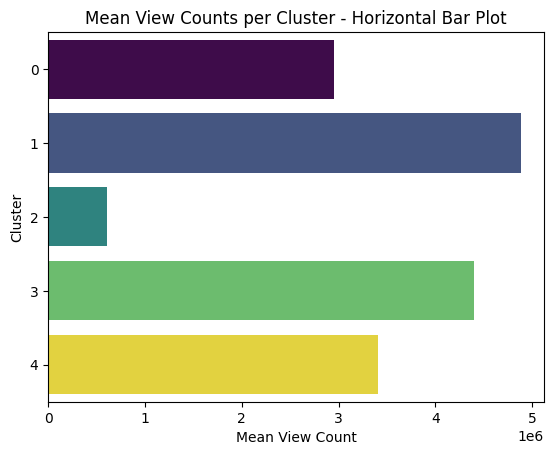

Cluster 0 Keywords:
keywords
funny     22
2         14
family    11
comedy    11
inside    11
davido    11
short     11
shorts    10
dance     10
live      10
Name: count, dtype: int64

Cluster 1 Keywords:
keywords
july          17
2024          17
day            8
shortvideo     8
new            7
viral          7
nsppd          7
dog            6
short          6
subscribe      6
Name: count, dtype: int64

Cluster 2 Keywords:
keywords
movie        71
2024         70
latest       40
nigerian     32
movies       23
yoruba       18
full         17
new          16
drama        15
nollywood    13
Name: count, dtype: int64

Cluster 3 Keywords:
keywords
shorts        71
trending      12
funny          7
funniest       6
gohan          5
shortvideo     5
dbz            5
spiderman      5
dance          5
vs             4
Name: count, dtype: int64

Cluster 4 Keywords:
keywords
official      38
video         32
music         13
x              8
olamide        6
visualizer     5
ft             

In [15]:

import pandas as pd
import re
import string
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import seaborn as sns


# Preprocess text
def preprocess_text(text):
    text = text.lower()
    text = re.sub(f"[{re.escape(string.punctuation)}]", "", text)
    text = re.sub(r'\s+', ' ', text).strip()
    return text

popular_videos['clean_title'] = popular_videos['title'].apply(preprocess_text)

# Extract keywords
nltk.download('punkt')
nltk.download('stopwords')
stop_words = set(stopwords.words('english'))

def extract_keywords(text):
    words = word_tokenize(text)
    keywords = [word for word in words if word.isalnum() and word not in stop_words]
    return keywords

popular_videos['keywords'] = popular_videos['clean_title'].apply(extract_keywords)

# Vectorize titles using TF-IDF
vectorizer = TfidfVectorizer(max_features=100)
X = vectorizer.fit_transform(popular_videos['clean_title']).toarray()

# Cluster videos using KMeans
num_clusters = 5
kmeans = KMeans(n_clusters=num_clusters,
                random_state=42,
                n_init=10)
popular_videos['cluster'] = kmeans.fit_predict(X)

# Plot view counts per cluster using an horizontal Bar Plotplt.figure(figsize=(12, 8))
view_counts_per_cluster = popular_videos.groupby('cluster')['view_count'].mean().reset_index()
sns.barplot(x='view_count', y='cluster',
            data=view_counts_per_cluster,
            palette='viridis', orient='h',
            hue='cluster', legend=False)
plt.title('Mean View Counts per Cluster - Horizontal Bar Plot')
plt.xlabel('Mean View Count')
plt.ylabel('Cluster')
plt.show()# Analyze the most common keywords in each cluster
for i in range(num_clusters):
    cluster_keywords = popular_videos[popular_videos['cluster'] == i]['keywords'].explode().value_counts().head(10)
    print(f"Cluster {i} Keywords:\n{cluster_keywords}\n")

Update the dataframe and export to csv

In [17]:
# Rename the 'cluster' column to 'video_cluster'
popular_videos.rename(columns={'cluster': 'video_cluster'}, inplace=True)

# Export the updated DataFrame to a CSV file
output_file = "/content/popular_videos_with_clusters.csv"
#popular_videos.to_csv(output_file, index=False)

print(f"Updated DataFrame exported to {output_file}")

# Display the first few rows to confirm the changes
popular_videos.head()


Updated DataFrame exported to /content/popular_videos_with_clusters.csv


,video_id,title,published_at,view_count,duration,duration_range,clean_title,keywords,video_cluster
0,Jz_ACml012M,blind man 🤣🤣#abdulbkcomedy #funny #newfunnycom...,2023-12-24T19:01:38Z,252504010,0 days 00:00:19,<10mins,blind man 🤣🤣abdulbkcomedy funny newfunnycomdey...,"[blind, man, funny, newfunnycomdey, comedy, pr...",0
1,DCmKq1eu-Rs,I Did the imposible 🤯🫣 #sherco #BIKE #HIGHT...,2024-04-03T10:10:54Z,220987865,0 days 00:00:13,<10mins,i did the imposible 🤯🫣 sherco bike hightclimbi...,"[imposible, sherco, bike, hightclimbing, endur...",1
2,7dok_dhNiMY,respect 😱🔥🤯,2024-06-16T13:50:09Z,56819874,0 days 00:00:25,<10mins,respect 😱🔥🤯,[respect],0
3,6mJzLrCGMb0,Catching fish with a dustpan Do you like this ...,2024-06-03T03:44:45Z,48723564,0 days 00:00:20,<10mins,catching fish with a dustpan do you like this ...,"[catching, fish, dustpan, like, kind, fishing,...",0
4,OLbUNiCBY6M,GTA V KARMA Spidey and Hulk #gta,2024-06-24T11:09:30Z,46645275,0 days 00:00:07,<10mins,gta v karma spidey and hulk gta,"[gta, v, karma, spidey, hulk, gta]",0
